# Setting the environment for Colab


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/w266_final/project_re"

/content/drive/.shortcut-targets-by-id/1I3W7Z7rz_YfsjBjX7z4zTzGbr-iKTrmD/w266_final/project_re


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 10.1MB/s 
     |████████████████████████████████| 1.1MB 55.8MB/s 
     |████████████████████████████████| 890kB 57.4MB/s 
     |████████████████████████████████| 2.9MB 48.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=7932e37416a76ec254d04ebd5778c8f523633c4d0e662bad7d382c50b95c3554
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import torch
import pickle
import numpy as np
from sklearn.metrics import matthews_corrcoef, confusion_matrix

from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.nn import CrossEntropyLoss, MSELoss

from tqdm import tqdm_notebook, trange
import os
#from pytorch_pretrained_bert import   BertForSequenceClassification, BertForTokenClassification
#from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule

from transformers import BertTokenizer, BertModel
from transformers import  BertForMaskedLM, BertForSequenceClassification, BertForTokenClassification
from transformers.optimization import AdamW

from transformers import AutoTokenizer, AutoModel

from model.MedClinical import Biobert_fc 

from multiprocessing import Pool, cpu_count
from util.tools  import *
from util import convert_examples_to_features

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [ ]:

DATA_DIR = "data_divided/"

# Bert pre-trained model selected in the list: bert-base-uncased, 
# bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased,
# bert-base-multilingual-cased, bert-base-chinese.
#BERT_MODEL = 'bert-base-uncased'

BERT_MODEL = 'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12'

# The name of the task to train.I'm going to name this 'yelp'.
TASK_NAME = 'Relation Extraction'

# The output directory where the fine-tuned model and checkpoints will be written.
OUTPUT_DIR = f'outputs/{TASK_NAME}/'

# The directory where the evaluation reports will be written to.
REPORTS_DIR = f'reports/{TASK_NAME}_evaluation_report/'

# This is where BERT will look for pre-trained models to load parameters from.
CACHE_DIR = 'cache/'

# The maximum total input sequence length after WordPiece tokenization.
# Sequences longer than this will be truncated, and sequences shorter than this will be padded.
MAX_SEQ_LENGTH = 128

TRAIN_BATCH_SIZE = 24
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 1e-5
NUM_TRAIN_EPOCHS = 10
RANDOM_SEED = 42
GRADIENT_ACCUMULATION_STEPS = 1
WARMUP_PROPORTION = 0.1


CONFIG_NAME = "config.json"
WEIGHTS_NAME = "pytorch_model.bin"

In [ ]:
if os.path.exists(REPORTS_DIR) and os.listdir(REPORTS_DIR):
        REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
        os.makedirs(REPORTS_DIR)
if not os.path.exists(REPORTS_DIR):
    os.makedirs(REPORTS_DIR)
    REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
    os.makedirs(REPORTS_DIR)

In [ ]:
# tokenizer = BertTokenizer.from_pretrained(OUTPUT_DIR + 'vocab.txt', do_lower_case=False)
#tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, do_lower_case=False)

INFO:filelock:Lock 140180123382784 acquired on /root/.cache/torch/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock


INFO:filelock:Lock 140180123382784 released on /root/.cache/torch/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock


In [ ]:
processor = MultiClassificationProcessor()
eval_examples = processor.get_dev_examples(DATA_DIR)
eval_examples_len = len(eval_examples)

In [ ]:
label_list = processor.get_labels() # [0, 1] for binary classification
num_labels = len(label_list)
num_labels

9

In [ ]:
eval_examples_for_processing = [(example,  MAX_SEQ_LENGTH, tokenizer) for example in eval_examples]

In [ ]:
process_count = cpu_count() - 1
with Pool(process_count) as p:
    eval_features = list(tqdm_notebook(p.imap(convert_examples_to_features.convert_example_to_feature, eval_examples_for_processing), total=eval_examples_len))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
all_label_ids = torch.tensor([int(f.label_id) for f in eval_features], dtype=torch.long)

In [ ]:
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=EVAL_BATCH_SIZE)

In [ ]:
## model = BertForSequenceClassification.from_pretrained(CACHE_DIR + BERT_MODEL, cache_dir=CACHE_DIR, num_labels=len(label_list))
# model = BertForSequenceClassification.from_pretrained(BERT_MODEL, cache_dir=CACHE_DIR, num_labels=num_labels)
# model = BertForSequenceClassification.from_pretrained(BERT_MODEL, cache_dir=CACHE_DIR, num_labels=num_labels)

#model = Biobert_fc()
# model =  BertModel.from_pretrained((BERT_MODEL))

model = AutoModel.from_pretrained(BERT_MODEL)

path = OUTPUT_DIR +  'pytorch_model.bin'
model.load_state_dict(torch.load(path))
model.eval()

INFO:filelock:Lock 140178954394704 acquired on /root/.cache/torch/transformers/b21d5a31a72925e995ffe402c1fc581bbcd2edeccfdfc99c644db9c8993b69c3.8a57b13360e7becd2face5c0f1f453e918ee57ca9cac6babc6a3081963efecbf.lock


INFO:filelock:Lock 140178954394704 released on /root/.cache/torch/transformers/b21d5a31a72925e995ffe402c1fc581bbcd2edeccfdfc99c644db9c8993b69c3.8a57b13360e7becd2face5c0f1f453e918ee57ca9cac6babc6a3081963efecbf.lock


INFO:filelock:Lock 140178954395152 acquired on /root/.cache/torch/transformers/bb92901d75bb47e4613bb4674299260f5771cccd3139fbeeaf2b3e29dae0ce57.2961ba715ddc7fc9de233b7f88e7cd685d828debe7fe8a96aed60b6b75358584.lock


INFO:filelock:Lock 140178954395152 released on /root/.cache/torch/transformers/bb92901d75bb47e4613bb4674299260f5771cccd3139fbeeaf2b3e29dae0ce57.2961ba715ddc7fc9de233b7f88e7cd685d828debe7fe8a96aed60b6b75358584.lock


Biobert_fc(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [ ]:
model.to(device)

Biobert_fc(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [ ]:

model.eval()
eval_loss = 0
nb_eval_steps = 0
preds = []

for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)

    with torch.no_grad():
        logits = model(input_ids, segment_ids, input_mask)

    # create eval loss and other metric required by the task
    loss_fct = CrossEntropyLoss()
    tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))

    eval_loss += tmp_eval_loss.mean().item()

    nb_eval_steps += 1
    if len(preds) == 0:
        preds.append(logits.detach().cpu().numpy())
    else:
        preds[0] = np.append(
            preds[0], logits.detach().cpu().numpy(), axis=0)

eval_loss = eval_loss / nb_eval_steps
preds = preds[0]
preds = np.argmax(preds, axis=1)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [ ]:
len(preds), len(all_label_ids)

(203, 203)

In [ ]:
def get_eval_report(task_name, labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    cm = confusion_matrix(labels, preds)
    return {
        "task": task_name,
        "mcc": mcc,
         "cm": cm
    }


def compute_metrics(task_name, labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(task_name, labels, preds)

In [ ]:
import json
CONFIG_FOLDER = 'config/'
id_label_file = 'id_2_label.json'
with open(CONFIG_FOLDER + id_label_file) as infile:
    id2label = json.load(infile)

In [ ]:
preds_labels = [id2label[str(p)] for p in preds]
all_labels =  [id2label[str(l)] for l in all_label_ids.numpy()]
mcc = matthews_corrcoef(all_labels, preds_labels)

print('Correlation Coefficient is ', mcc)

mismatches = []
all_rels = []
for row in range(len(all_labels)):
    all_rels.append([all_labels[row], preds_labels[row]])
    if preds_labels[row] != all_labels[row]:
        mismatches.append([all_labels[row], preds_labels[row]])
        

        

Correlation Coefficient is  -0.2062349036103267


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


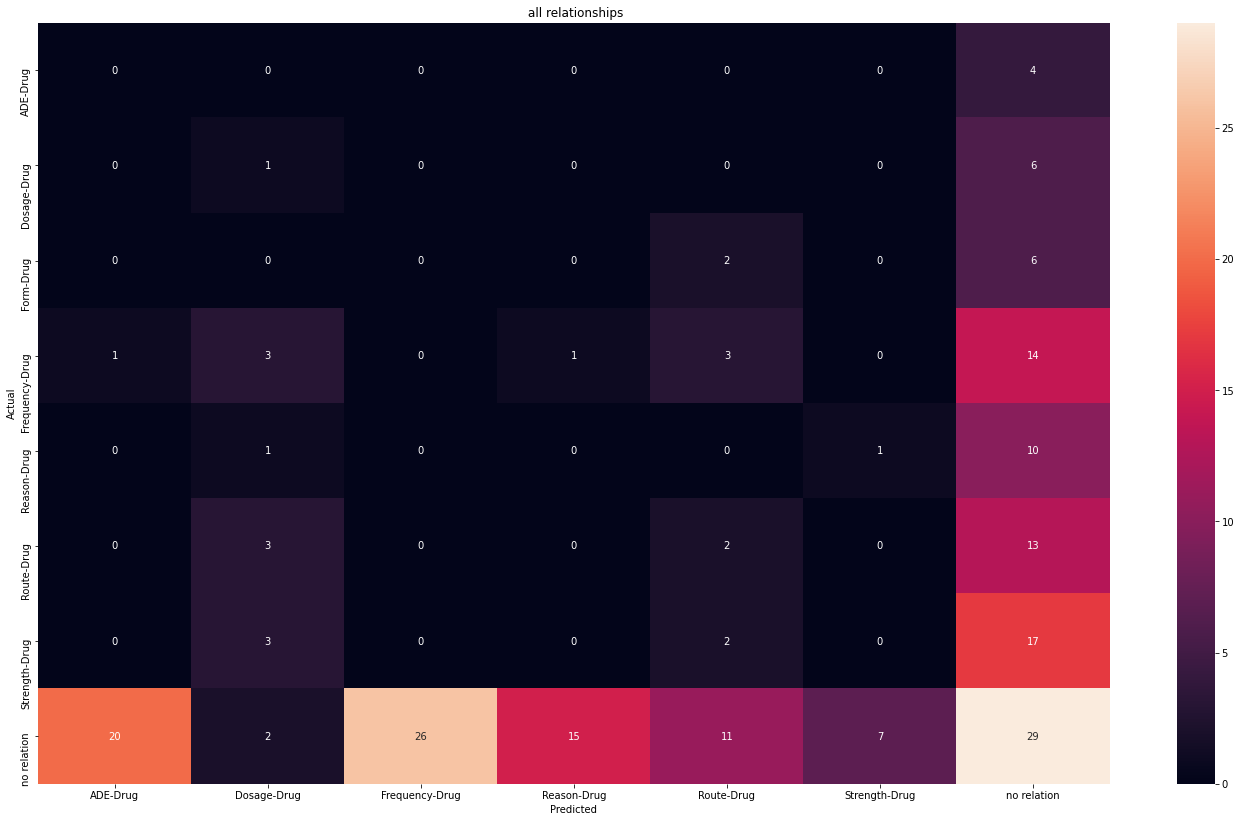

In [ ]:
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

df = pd.DataFrame(all_rels, columns = ['labels', 'predicted'])
# df.head(10)
plt.figure(figsize=(24,14))
plt.title(" all relationships")
confusion_matrix = pd.crosstab(df['labels'], df['predicted'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

plt.show()


In [ ]:
df

,labels,predicted
0,Route-Drug,no relation
1,no relation,no relation
2,Route-Drug,no relation
3,ADE-Drug,no relation
4,Reason-Drug,no relation
...,...,...
198,no relation,ADE-Drug
199,Frequency-Drug,no relation
200,no relation,Frequency-Drug
201,no relation,Route-Drug


In [ ]:
from sklearn import metrics
metrics.f1_score(df["labels"], df["predicted"], average='micro')

0.15763546798029557

In [ ]:
df["matched"] = df["labels"] == df["predicted"]
# df["nomatch"] = df["labels"] != df["predicted"]
df.groupby(["labels", "matched"]).count()

predicted
labels         matched           
ADE-Drug       False            4
Dosage-Drug    False            6
               True             1
Form-Drug      False            8
Frequency-Drug False           22
Reason-Drug    False           12
Route-Drug     False           16
               True             2
Strength-Drug  False           22
no relation    False           81
               True            29

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df["labels"], df["predicted"]))

                precision    recall  f1-score   support

      ADE-Drug       0.00      0.00      0.00         4
   Dosage-Drug       0.08      0.14      0.10         7
     Form-Drug       0.00      0.00      0.00         8
Frequency-Drug       0.00      0.00      0.00        22
   Reason-Drug       0.00      0.00      0.00        12
    Route-Drug       0.10      0.11      0.11        18
 Strength-Drug       0.00      0.00      0.00        22
   no relation       0.29      0.26      0.28       110

      accuracy                           0.16       203
     macro avg       0.06      0.06      0.06       203
  weighted avg       0.17      0.16      0.16       203



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
